In [26]:
import numpy as np
import os
import cv2 as cv
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter
import random

def random_crop(image, crop_size):
    width, height = image.size
    left = random.randint(0, width - crop_size[0])
    top = random.randint(0, height - crop_size[1])
    right = left + crop_size[0]
    bottom = top + crop_size[1]
    return image.crop((left, top, right, bottom))

def random_flip(image):
    if random.choice([True, False]):
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_rotation(image, max_angle):
    angle = random.uniform(-max_angle, max_angle)
    return image.rotate(angle)

def random_scale(image, scale_range):
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    new_size = tuple(int(dim * scale_factor) for dim in image.size)
    return image.resize(new_size, Image.BICUBIC)

def random_shift(image, shift_range):
    shift_x = random.randint(shift_range[0], shift_range[1])
    shift_y = random.randint(shift_range[0], shift_range[1])
    return image.transform(image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

def add_gaussian_noise(image, mean=0, std=25):
    width, height = image.size
    gaussian_noise = ImageFilter.GaussianBlur(radius=random.gauss(mean, std))
    return Image.blend(image, image.filter(gaussian_noise), alpha=random.uniform(0.1, 0.5))

def color_jitter(image, brightness_factor=0.5, contrast_factor=0.5, saturation_factor=0.5):
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1 + random.uniform(-brightness_factor, brightness_factor))

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + random.uniform(-contrast_factor, contrast_factor))

    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(1 + random.uniform(-saturation_factor, saturation_factor))

    return image

def image_augmentation(image_path, save_path):
    original_image = Image.open(image_path)

    # Save original image
    original_image.save(os.path.join(save_path, 'Orogin.jpg'))

    # 裁剪
    crop_size = (original_image.width // 2, original_image.height // 2)
    cropped_image = random_crop(original_image, crop_size)
    cropped_image.save(os.path.join(save_path, 'cropped.jpg'))

    # 翻转
    flipped_image = random_flip(cropped_image)
    flipped_image.save(os.path.join(save_path, 'flipped.jpg'))

    # 旋转
    rotated_image = random_rotation(flipped_image, max_angle=30)
    rotated_image.save(os.path.join(save_path, 'rotated.jpg'))

    # 缩放
    scaled_image = random_scale(rotated_image, scale_range=(0.8, 1.2))
    scaled_image.save(os.path.join(save_path, 'scaled.jpg'))

    # 移位
    shifted_image = random_shift(scaled_image, shift_range=(-20, 20))
    shifted_image.save(os.path.join(save_path, 'shifted.jpg'))

    # 高斯噪声
    noisy_image = add_gaussian_noise(shifted_image)
    noisy_image.save(os.path.join(save_path, 'noisy.jpg'))

    # 色彩抖动
    jittered_image = color_jitter(noisy_image)
    jittered_image.save(os.path.join(save_path, 'jittered.jpg'))

    # 将彩色图像转换为灰度图像
    gray_image = jittered_image.convert("L")
    gray_image.save(os.path.join(save_path, 'final_gray.jpg'))

    result = np.array(gray_image)

    return result

# Directory to save intermediate augmented images
save_path = ''

# Ensure the directory exists
os.makedirs('hahhaha', exist_ok=True)

# 读取xlsx文件
file_path = '成熟度.xlsx'
df = pd.read_excel(file_path)

# 使用replace方法替换值
df['标签'] = df['标签'].replace({'熟': 0, '不熟': 1})

# 显示数据大小
print(df.shape)

# 转成dict
label = df.set_index('序号').to_dict()['标签']

#设定图像宽高
imgwidth = 270
imgheight = 180

imgdata_train = []
imgtag_train = []
imgdata_test = []
imgtag_test = []

# 获取指定路径下的所有文件和文件夹
directory = '/Users/zhangying/iCloud Drive (Archive) - 2/Desktop/Andrea/Academic 学术/建模资料/亚太地区A题解题/Attachment 1'
files = os.listdir(directory)

# 遍历文件和文件夹
for file in files:
    # 获取文件或文件夹的完整路径
    image_path = os.path.join(directory, file)
    if image_path[-3:] == "jpg":
        id = int(image_path.split('/')[-1].split('.')[0])
        print(id)
        # id为类目
        if id in label.keys():
            # 加载图像
            img = cv.imread(image_path, 0)
            img = cv.resize(img, (imgheight, imgwidth))
            # if random.uniform(0, 10) < 8:
            imgdata_train.append(img)
            imgtag_train.append(label[id])
            if random.uniform(0, 10) < 3:
            # else:
                imgdata_test.append(img)
                imgtag_test.append(label[id])
            # 数据增强
            intermediate_save_path = os.path.join(save_path)
            for i in range(10):
                img_enhance = image_augmentation(image_path, intermediate_save_path)
                img_enhance = cv.resize(img_enhance, (imgheight, imgwidth))
                # if random.uniform(0, 10) < 8:
                imgdata_train.append(img_enhance)
                imgtag_train.append(label[id])
                if random.uniform(0, 10) < 3:
                    imgdata_test.append(img_enhance)
                    imgtag_test.append(label[id])

imgtag_train = np.array(imgtag_train)
imgdata_train = np.array(imgdata_train)
imgtag_train = imgtag_train.reshape(imgtag_train.shape[0],1)
imgtag_test = np.array(imgtag_test)
imgdata_test = np.array(imgdata_test)
imgtag_test = imgtag_test.reshape(imgtag_test.shape[0],1)

#增加一维灰度维
imgdata_train = imgdata_train.reshape(imgdata_train.shape[0],imgdata_train.shape[1],imgdata_train.shape[2],1)
print(imgdata_train.shape,imgtag_train.shape)
imgdata_test = imgdata_test.reshape(imgdata_test.shape[0],imgdata_test.shape[1],imgdata_test.shape[2],1)
print(imgdata_test.shape,imgtag_test.shape)
#存储
np.save("./x_train.npy",imgdata_train)
np.save("./y_train.npy",imgtag_train)
np.save("./x_test.npy",imgdata_test)
np.save("./y_test.npy",imgtag_test)


(196, 2)
63
189
77
162
176
88
200
177
89
163
188
76
62
74
60
48
149
175
161
160
174
148
49
61
75
59
71
65
170
164
158
159
165
171
64
70
58
8
198
66
72
167
99
173
172
166
98
73
199
67
9
14
28
129
101
115
114
100
128
29
15
17
116
102
103
117
16
12
113
107
106
112
13
39
11
104
110
138
139
111
105
10
38
21
35
108
120
134
135
121
109
34
20
36
22
137
123
122
136
23
37
33
27
132
126
127
133
26
32
18
24
30
125
131
119
118
130
124
31
25
19
42
4
56
180
194
81
95
143
157
156
142
94
80
195
181
5
57
43
55
7
41
69
197
183
96
168
82
154
140
141
155
83
97
169
182
68
196
40
54
6
192
78
186
2
50
44
151
145
93
87
179
86
178
92
144
150
45
3
51
79
187
193
185
191
47
53
1
146
152
84
90
91
85
153
147
52
46
190
184
(2156, 270, 180, 1) (2156, 1)
(619, 270, 180, 1) (619, 1)


In [25]:
import numpy as np
import os
import cv2 as cv
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter
import random

def random_crop(image, crop_size):
    width, height = image.size
    left = random.randint(0, width - crop_size[0])
    top = random.randint(0, height - crop_size[1])
    right = left + crop_size[0]
    bottom = top + crop_size[1]
    return image.crop((left, top, right, bottom))

def random_flip(image):
    if random.choice([True, False]):
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_rotation(image, max_angle):
    angle = random.uniform(-max_angle, max_angle)
    return image.rotate(angle)

def random_scale(image, scale_range):
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    new_size = tuple(int(dim * scale_factor) for dim in image.size)
    return image.resize(new_size, Image.BICUBIC)

def random_shift(image, shift_range):
    shift_x = random.randint(shift_range[0], shift_range[1])
    shift_y = random.randint(shift_range[0], shift_range[1])
    return image.transform(image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

def add_gaussian_noise(image, mean=0, std=25):
    width, height = image.size
    gaussian_noise = ImageFilter.GaussianBlur(radius=random.gauss(mean, std))
    return Image.blend(image, image.filter(gaussian_noise), alpha=random.uniform(0.1, 0.5))

def color_jitter(image, brightness_factor=0.5, contrast_factor=0.5, saturation_factor=0.5):
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1 + random.uniform(-brightness_factor, brightness_factor))

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + random.uniform(-contrast_factor, contrast_factor))

    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(1 + random.uniform(-saturation_factor, saturation_factor))

    return image

def image_augmentation(image_path):
    original_image = Image.open(image_path)

    # 裁剪
    crop_size = (original_image.width // 2, original_image.height // 2)
    cropped_image = random_crop(original_image, crop_size)

    # 翻转
    flipped_image = random_flip(cropped_image)

    # 旋转
    rotated_image = random_rotation(flipped_image, max_angle=30)

    # 缩放
    scaled_image = random_scale(rotated_image, scale_range=(0.8, 1.2))

    # 移位
    shifted_image = random_shift(scaled_image, shift_range=(-20, 20))

    # 高斯噪声
    noisy_image = add_gaussian_noise(shifted_image)

    # 色彩抖动
    jittered_image = color_jitter(noisy_image)

    # 将彩色图像转换为灰度图像
    gray_image = jittered_image.convert("L")
    result = np.array(gray_image)

    return result
# 获取指定路径下的所有文件和文件夹
directory = '/Users/zhangying/iCloud Drive (Archive) - 2/Desktop/Andrea/Academic 学术/建模资料/亚太地区A题解题/Attachment 1'
files = os.listdir(directory)

# 遍历文件和文件夹
for file in files:
    # 获取文件或文件夹的完整路径
    image_path = os.path.join(directory, file)
    if image_path[-3:] == "jpg":
        id = int(image_path.split('/')[-1].split('.')[0])
        print(id)
        # id为类目
        if id in label.keys():
            # 加载图像
            img = cv.imread(image_path, 0)
            img = cv.resize(img, (imgheight, imgwidth))
            # if random.uniform(0, 10) < 8:
            imgdata_train.append(img)
            imgtag_train.append(label[id])
            if random.uniform(0, 10) < 3:
            # else:
                imgdata_test.append(img)
                imgtag_test.append(label[id])
            # 数据增强
            for i in range(10):
                img_enhance = image_augmentation(image_path)
                img_enhance = cv.resize(img_enhance, (imgheight, imgwidth))
                # if random.uniform(0, 10) < 8:
                imgdata_train.append(img_enhance)
                imgtag_train.append(label[id])
                if random.uniform(0, 10) < 3:
                    imgdata_test.append(img_enhance)
                    imgtag_test.append(label[id])

63


AttributeError: 'numpy.ndarray' object has no attribute 'append'

接下来的这串代码我要实现的是，运行老师的代码，算出成熟度


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 270, 180, 32)      320       
                                                                 
 activation_4 (Activation)   (None, 270, 180, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 135, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 135, 90, 32)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 135, 90, 64)       18496     
                                                                 
 activation_5 (Activation)   (None, 135, 90, 64)       0         
                                                      

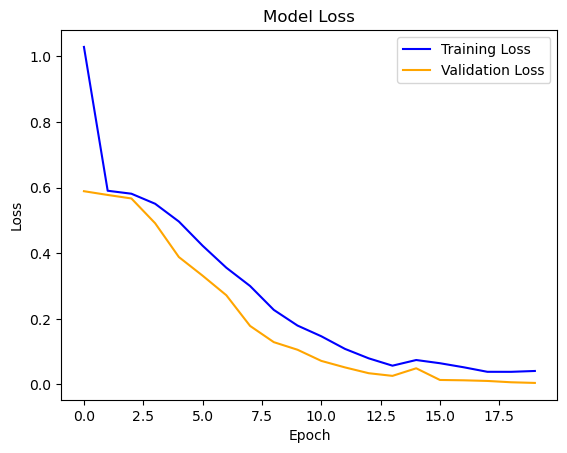

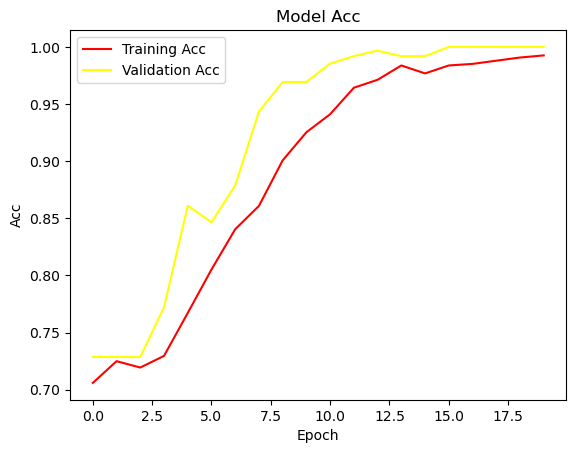

In [28]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np

#2类分类
num_classes = 2
nppath = "./"

#加载数据
x_train = np.load(nppath + "x_train.npy")
# x_test = np.load(nppath + "x_train.npy")
x_test = np.load(nppath + "x_test.npy")
y_train = np.load(nppath + "y_train.npy")
# y_test = np.load(nppath + "y_train.npy")
y_test = np.load(nppath + "y_test.npy")

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# 此优化器对本实验不适用
#opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

# train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# hist = model.fit(x_train, y_train, epochs=100, shuffle=True)
# model.save("./cnnmodel.h5")
#
# # evaluate
# loss, accuracy = model.evaluate(x_test, y_test)
# print(loss, accuracy)

import matplotlib.pyplot as plt

def plot_loss(history):
    # 提取训练集和验证集的损失值
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # 设置图表标题和标签
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # 绘制训练集和验证集的损失曲线
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')

    # 添加图例
    plt.legend()

    # 显示图表
    plt.show()


def plot_acc(history):
    # 提取训练集和验证集的准确率
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # 设置图表标题和标签
    plt.title('Model Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')

    # 绘制训练集和验证集的损失曲线
    plt.plot(train_accuracy, label='Training Acc', color='red')
    plt.plot(val_accuracy, label='Validation Acc', color='yellow')

    # 添加图例
    plt.legend()

    # 显示图表
    plt.show()

# 训练模型并记录训练历史
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=16, verbose=0)

# 绘制损失曲线
plot_loss(history)
plot_acc(history)